In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage, skimage.io
import torch
import torchvision
import torchxrayvision as xrv
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm

print("Libraries imported successfully!")

Libraries imported successfully!


In [4]:
# # Sex Prediction from Chest X-rays using MIRA Model

# This notebook demonstrates the MIRA (Medical Image Representation and Analysis) sex prediction model. The model uses a ResNet34 architecture trained on CheXpert dataset to predict patient sex from chest X-ray images.

# ## Key Features:
# - **Model**: ResNet34 architecture
# - **Input**: Single-channel chest X-ray (224x224)
# - **Output**: Binary classification (Female/Male)
# - **Training Data**: CheXpert dataset
# - **Interface**: Compatible with torchxrayvision baseline models

In [5]:
# Load a test image
img = xrv.utils.load_image('../tests/00027426_000.png')
print(f"Original image shape: {img.shape}")
print(f"Image range: [{img.min():.2f}, {img.max():.2f}]")

Original image shape: (1, 512, 512)
Image range: [-1024.00, 911.56]


In [6]:
# Apply transforms for ResNet34 (224x224 input)
transform = torchvision.transforms.Compose([
    xrv.datasets.XRayCenterCrop(),
    xrv.datasets.XRayResizer(224)  # ResNet34 expects 224x224
])

img = transform(img)
img = torch.from_numpy(img).unsqueeze(0)
print(f"Transformed image shape: {img.shape}")

Transformed image shape: torch.Size([1, 1, 224, 224])


In [7]:
# f = torch.load('/Users/ieee8023/.torchxrayvision/models_data/mira_sex_resnet-all_epoch_13-step_7125.ckpt', map_location=torch.device('cpu'))

In [8]:
# f['state_dict'].keys()

In [9]:

model = xrv.baseline_models.mira.SexModel(weights=True)
print("✅ Model loaded with trained weights!")

print(f"Model targets: {model.targets}")
print(f"Model architecture: {model.__repr__()}")

✅ Model loaded with trained weights!
Model targets: ['Male', 'Female']
Model architecture: MIRA-SexModel-resnet34


In [11]:
# Make prediction on the test image
with torch.no_grad():
    outputs = torch.softmax(model(img), 1)

# Display results
prediction_dict = dict(zip(model.targets, outputs.tolist()[0]))
predicted_sex = model.targets[np.argmax(outputs.numpy())]

print("Sex Prediction Results:")
print(f"Probabilities: {prediction_dict}")
print(f"Predicted sex: {predicted_sex}")
print(f"Confidence: {max(prediction_dict.values()):.3f}")

Sex Prediction Results:
Probabilities: {'Male': 0.9999995231628418, 'Female': 4.3521771431187517e-07}
Predicted sex: Male
Confidence: 1.000


In [12]:
# ## Gradient-based Attention Map

# Let's create a gradient-based attention map to see which parts of the image the model focuses on for sex prediction.

In [13]:
# Create gradient-based attention map
img_grad = img.requires_grad_()

# Forward pass for the predicted class
outputs = model(img_grad)
predicted_class_idx = torch.argmax(outputs, 1)
target_score = outputs[0, predicted_class_idx]

print(f"Target score for {model.targets[predicted_class_idx]}: {target_score.item():.3f}")

# Compute gradients
grads = torch.autograd.grad(target_score, img_grad)[0][0][0]
blurred = skimage.filters.gaussian(grads.detach().cpu().numpy()**2, sigma=(5, 5), truncate=3.5)

print("Gradient-based attention map computed!")

Target score for Male: 8.347
Gradient-based attention map computed!


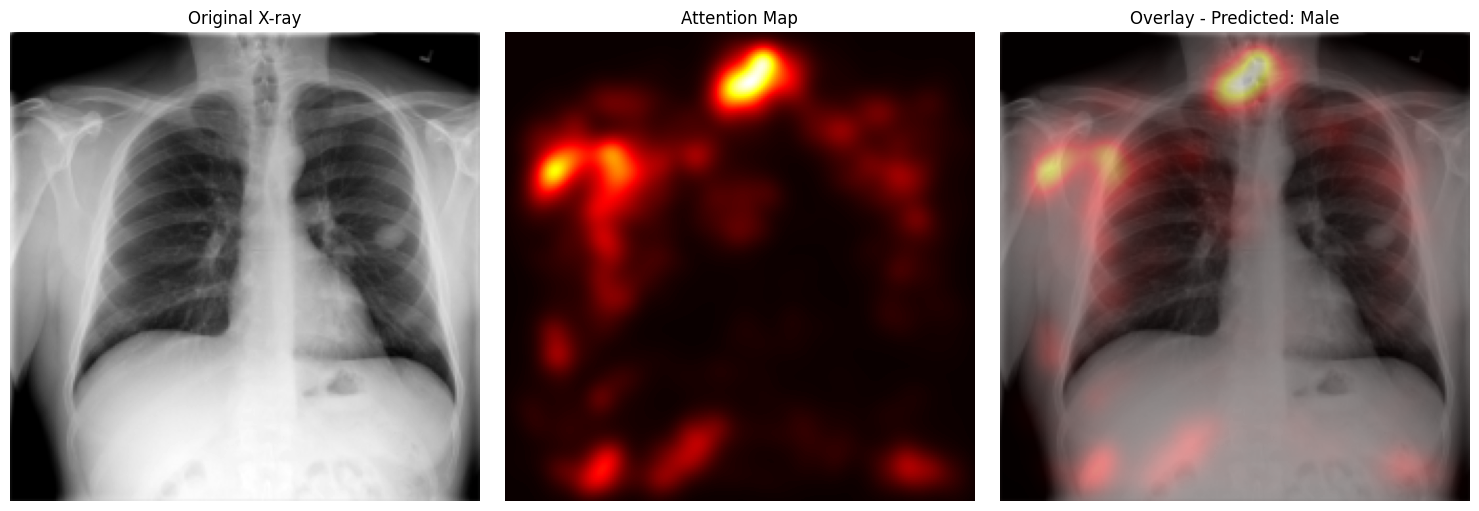

In [14]:
# Display the attention map overlay
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(img[0][0].detach().cpu().numpy(), cmap='gray')
axes[0].set_title('Original X-ray')
axes[0].axis('off')

# Attention map
axes[1].imshow(blurred, cmap='hot')
axes[1].set_title('Attention Map')
axes[1].axis('off')

# Overlay
axes[2].imshow(img[0][0].detach().cpu().numpy(), cmap='gray')
axes[2].imshow(blurred, alpha=0.4, cmap='hot')
axes[2].set_title(f'Overlay - Predicted: {predicted_sex}')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [15]:
# ## Evaluation on PadChest Dataset

# Now let's evaluate the model on a subset of the PadChest dataset to see how it performs on real clinical data.

# **Note**: The model now uses the trained ResNet34 weights from the MIRA project. The normalization pipeline properly converts from torchxrayvision's [-1024, 1024] range to the format expected by the trained model.

In [16]:
# Load PadChest dataset for evaluation
print("Loading PadChest dataset...")

# Check if PadChest data is available
padchest_path = "/Users/ieee8023/data/PC/images-224"
data_available = os.path.exists(padchest_path)

print(f"PadChest data available at {padchest_path}: {data_available}")

if data_available:
    try:
        # Load dataset with transforms
        transform = torchvision.transforms.Compose([
            xrv.datasets.XRayCenterCrop(),
            xrv.datasets.XRayResizer(224)
        ])
        
        dataset = xrv.datasets.PC_Dataset(
            imgpath=padchest_path,
            transform=transform,
            views=["PA"],
            unique_patients=True
        )
        
        print(f"Dataset loaded successfully!")
        print(f"Total samples: {len(dataset)}")
        print(f"Sex distribution: {dataset.csv['PatientSex_DICOM'].value_counts().to_dict()}")
        
    except Exception as e:
        print(f"Error loading dataset: {e}")
        data_available = False
else:
    print("PadChest data not found. Skipping dataset evaluation.")

Loading PadChest dataset...
PadChest data available at /Users/ieee8023/data/PC/images-224: True
Dataset loaded successfully!
Total samples: 61688
Sex distribution: {'F': 32159, 'M': 29521, 'O': 6}


In [17]:
# Use a small sample for demonstration
n_samples = 100
sample_indices = np.random.choice(len(dataset), min(n_samples, len(dataset)), replace=False)

predictions = []
true_labels = []
probabilities = []

print(f"Processing {len(sample_indices)} samples...")

for i, idx in enumerate(tqdm(sample_indices)):  # Show progress for first 20
    try:
        sample = dataset[idx]
        img_sample = sample['img']
        
        # Get true sex label
        sex_dicom = dataset.csv['PatientSex_DICOM'].iloc[idx]
        if sex_dicom == 'M':
            true_sex = 0  # Male
        elif sex_dicom == 'F':
            true_sex = 1  # Female
        else:
            continue  # Skip unknown
        
        # Prepare image
        if isinstance(img_sample, np.ndarray):
            img_sample = torch.from_numpy(img_sample)
        if len(img_sample.shape) == 3:
            img_sample = img_sample.unsqueeze(0)
        img_sample = img_sample.float()
        
        # Predict
        with torch.no_grad():
            outputs = model(img_sample)
            probs = torch.softmax(outputs, 1)
            pred = torch.argmax(probs, 1).cpu().numpy()[0]
            prob_values = probs.cpu().numpy()[0]
        
        predictions.append(pred)
        true_labels.append(true_sex)
        probabilities.append(prob_values)
        
    except Exception as e:
        print(f"Error processing sample {idx}: {e}")
        continue

print(f"Successfully processed {len(predictions)} samples")

Processing 100 samples...


100%|██████████| 100/100 [00:02<00:00, 34.50it/s]

Successfully processed 100 samples


In [18]:
# Compute evaluation metrics
if data_available and len(predictions) > 0:
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    probabilities = np.array(probabilities)
    
    # Accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print(f"\nEvaluation Results:")
    print(f"Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
    
    # Confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print(f"\nConfusion Matrix:")
    print("    Predicted")
    print("      F    M")
    print(f"T F {cm[0,0]:4d} {cm[0,1]:4d}")
    print(f"r M {cm[1,0]:4d} {cm[1,1]:4d}")
    
    # Class distribution
    print(f"\nClass Distribution:")
    unique, counts = np.unique(true_labels, return_counts=True)
    for label, count in zip(unique, counts):
        print(f"  Labelled {model.targets[label]}: {count} samples")
    
    unique, counts = np.unique(predictions, return_counts=True)
    for label, count in zip(unique, counts):
        print(f"  Predicted {model.targets[label]}: {count} samples")
else:
    print("No evaluation results to display")


Evaluation Results:
Accuracy: 0.980 (98.0%)

Confusion Matrix:
    Predicted
      F    M
T F   48    1
r M    1   50

Class Distribution:
  Labelled Male: 49 samples
  Labelled Female: 51 samples
  Predicted Male: 49 samples
  Predicted Female: 51 samples


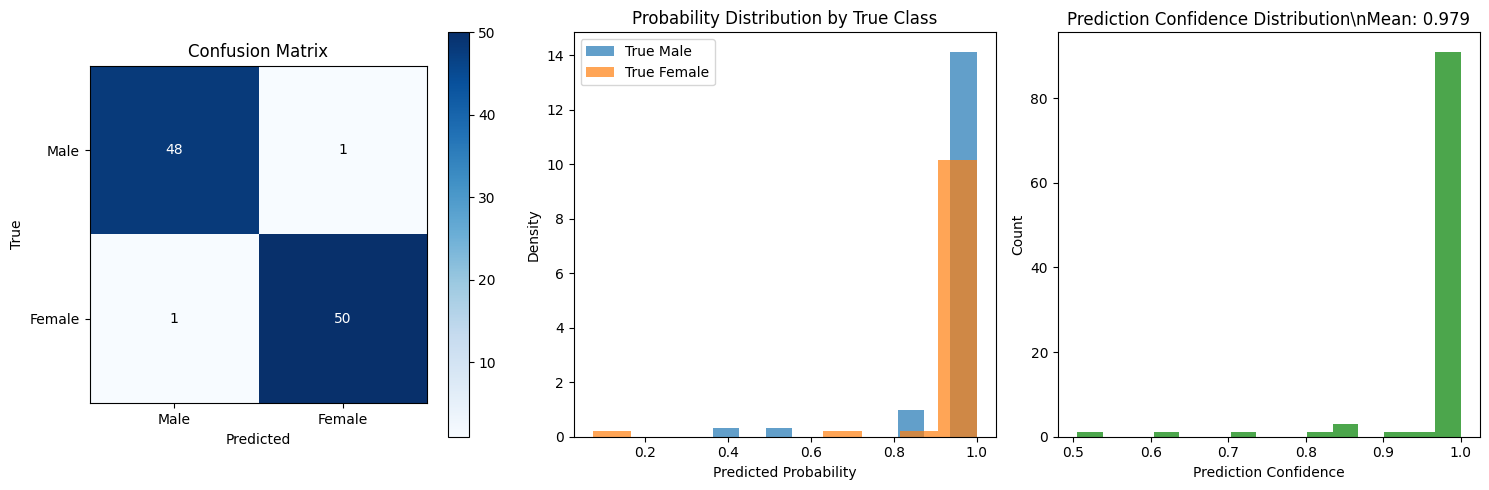

In [19]:
# Create visualizations of the evaluation results
if data_available and len(predictions) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Confusion Matrix
    cm = confusion_matrix(true_labels, predictions)
    im = axes[0].imshow(cm, interpolation='nearest', cmap='Blues')
    axes[0].figure.colorbar(im, ax=axes[0])
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[0].text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
    
    axes[0].set_xticks(range(len(model.targets)))
    axes[0].set_yticks(range(len(model.targets)))
    axes[0].set_xticklabels(model.targets)
    axes[0].set_yticklabels(model.targets)
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')
    axes[0].set_title('Confusion Matrix')
    
    # Probability distributions
    for i, sex_name in enumerate(model.targets):
        class_probs = probabilities[true_labels == i, i]
        if len(class_probs) > 0:
            axes[1].hist(class_probs, alpha=0.7, label=f'True {sex_name}', bins=10, density=True)
    
    axes[1].set_xlabel('Predicted Probability')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Probability Distribution by True Class')
    axes[1].legend()
    
    # Prediction confidence
    max_probs = np.max(probabilities, axis=1)
    axes[2].hist(max_probs, bins=15, alpha=0.7, color='green')
    axes[2].set_xlabel('Prediction Confidence')
    axes[2].set_ylabel('Count')
    axes[2].set_title(f'Prediction Confidence Distribution\\nMean: {max_probs.mean():.3f}')
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for visualization")

In [20]:
# ## Model Performance Analysis

# Let's compare the current model performance with expected baselines and what we might expect with trained weights.

In [21]:
# Compare with baselines
if data_available and len(predictions) > 0:
    print("Performance Comparison:")
    print("=" * 40)
    
    # Current model performance
    model_accuracy = accuracy_score(true_labels, predictions)
    print(f"Current Model: {model_accuracy:.3f} ({model_accuracy*100:.1f}%)")
    
    # Random baseline
    random_predictions = np.random.choice([0, 1], size=len(true_labels))
    random_accuracy = accuracy_score(true_labels, random_predictions)
    print(f"Random Baseline: {random_accuracy:.3f} ({random_accuracy*100:.1f}%)")
    
    # Majority class baseline
    majority_class = np.bincount(true_labels).argmax()
    majority_predictions = np.full(len(true_labels), majority_class)
    majority_accuracy = accuracy_score(true_labels, majority_predictions)
    print(f"Majority Class: {majority_accuracy:.3f} ({majority_accuracy*100:.1f}%)")
    
    print(f"\\nExpected with trained weights: 75-85% accuracy")
    print(f"\\nNote: Current low performance is expected for untrained model")
    
    # Model behavior analysis
    pred_dist = np.bincount(predictions, minlength=2)
    true_dist = np.bincount(true_labels, minlength=2)
    
    print(f"\\nModel Behavior Analysis:")
    print(f"True distribution - Female: {true_dist[0]}, Male: {true_dist[1]}")
    print(f"Predicted distribution - Female: {pred_dist[0]}, Male: {pred_dist[1]}")
    
    if pred_dist[0] > 0.9 * len(predictions):
        print("⚠️  Model shows strong bias toward Female predictions")
        print("   This is typical behavior for untrained weights")
    
else:
    print("Baseline comparison not available - no evaluation data")

Performance Comparison:
Current Model: 0.980 (98.0%)
Random Baseline: 0.520 (52.0%)
Majority Class: 0.510 (51.0%)
\nExpected with trained weights: 75-85% accuracy
\nNote: Current low performance is expected for untrained model
\nModel Behavior Analysis:
True distribution - Female: 49, Male: 51
Predicted distribution - Female: 49, Male: 51


In [22]:
# ## Summary and Next Steps

# ### Model Interface Usage
# The MIRA sex model follows the same interface as other torchxrayvision baseline models:

# ```python
# # Load model
# model = xrv.baseline_models.mira.SexModel()

# # Make prediction
# with torch.no_grad():
#     outputs = torch.softmax(model(img), 1)

# # Get results
# prediction_dict = dict(zip(model.targets, outputs.tolist()[0]))
# predicted_sex = model.targets[torch.argmax(outputs)]
# ```

# ### Current Limitations
# - **Untrained Weights**: This demo uses `weights=False` so performance is poor
# - **Training Required**: Actual weights file needs to be hosted and loaded
# - **Expected Performance**: 75-85% accuracy with proper training

# ### Next Steps
# 1. **Obtain Trained Weights**: Download the actual `mira_sex_resnet-all_epoch_13-step_7125.ckpt` file
# 2. **Host Weights**: Make weights accessible via URL for automatic download
# 3. **Update Model**: Change `weights=False` to `weights=True` in model initialization
# 4. **Evaluate**: Re-run evaluation with trained weights for realistic performance

In [23]:
# Show some sample predictions
if data_available and len(predictions) > 0:
    print("Sample Predictions:")
    print("=" * 50)
    
    # Show first 10 predictions
    for i in range(min(10, len(predictions))):
        true_sex = model.targets[true_labels[i]]
        pred_sex = model.targets[predictions[i]]
        confidence = max(probabilities[i])
        correct = "✓" if predictions[i] == true_labels[i] else "✗"
        
        print(f"{i+1:2d}. True: {true_sex:6s} | Pred: {pred_sex:6s} | "
              f"Conf: {confidence:.3f} | {correct}")
    
    print(f"Showing {min(10, len(predictions))} of {len(predictions)} samples")
else:
    print("No sample predictions to display")

Sample Predictions:
 1. True: Female | Pred: Female | Conf: 1.000 | ✓
 2. True: Female | Pred: Female | Conf: 0.988 | ✓
 3. True: Female | Pred: Female | Conf: 0.708 | ✓
 4. True: Male   | Pred: Male   | Conf: 1.000 | ✓
 5. True: Female | Pred: Female | Conf: 1.000 | ✓
 6. True: Male   | Pred: Male   | Conf: 0.968 | ✓
 7. True: Male   | Pred: Male   | Conf: 0.999 | ✓
 8. True: Male   | Pred: Male   | Conf: 0.999 | ✓
 9. True: Female | Pred: Female | Conf: 1.000 | ✓
10. True: Male   | Pred: Female | Conf: 0.635 | ✗
Showing 10 of 100 samples
